# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
from utils import *
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [2]:
model = ResNet50()

finetune2() removes the dense layers and final pooling layer and replaces them with:
- An Average and Max Pooling Layer concatenated together
- Adds Batchnormalization
- Adds Dropout
- Adds Dense layers to predict num_classes

it also freezes all convolutional layers

In [3]:
# pool_layer = [layer for layer in model.layers if layer.name == 'avg_pool'][0]
# model = finetune2(model,pool_layer,2)

In [4]:
model = finetune(model,2)

We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [5]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
batch_size = 64
sz = 224

In [6]:
center = CenterCrop(sz)
randCrop = RandCrop(sz)

In [7]:
batches = ImageDataGenerator(preprocessing_function=randCrop).flow_from_directory(path+'train', target_size=(sz,sz),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [8]:
val_batches = ImageDataGenerator(preprocessing_function=center).flow_from_directory(path+'valid', target_size=(sz,sz),
                class_mode='categorical', shuffle=False, batch_size=batch_size*4)

Found 2000 images belonging to 2 classes.


The LR_Find callback is utilized to find a good starting learning rate

In [9]:
epochs = 1
callback_list = []
lr_find = LR_Find(math.ceil(batches.samples/batch_size),jump=5)
callback_list.append(lr_find)

In [10]:
sgd = optimizers.SGD(lr=1e-05, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd)

In [11]:
model.fit_generator(batches, steps_per_epoch=math.ceil(batches.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list,
                   )

Epoch 1/1
269/360 [=====================>........] - ETA: 16s - loss: 0.6231

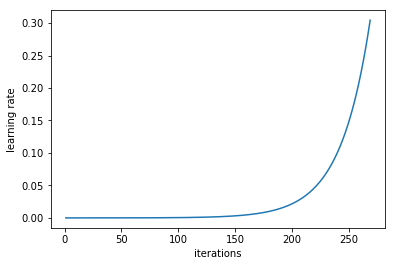

In [12]:
lr_find.plot_lr()

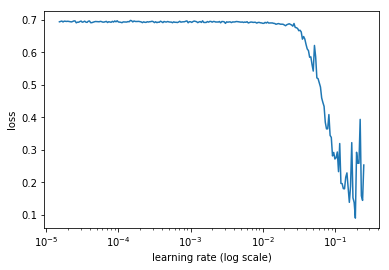

In [13]:
lr_find.plot()

As you can see in the plot above it appears the optimal learning rate to set is .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [14]:
#need to add random lighten
batches_aug = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True,
                                preprocessing_function=randCrop).flow_from_directory(path+'train', target_size=(sz,sz),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [15]:
epochs = 4
callback_list = []
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [16]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/4
  8/360 [..............................] - ETA: 152s - loss: 0.6946 - acc: 0.4570

KeyboardInterrupt: 

Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

In [18]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.096999867448149743, 0.96742327365728897]

Fit for 3 epochs with a Cyclical Learning Rate

In [19]:
epochs = 3
callback_list = []
lr_cycle = LR_Cycle(math.ceil(batches_aug.samples/batch_size), cycle_mult=2)
callback_list.append(lr_cycle)

In [20]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/3
360/360 [==============================] - 147s - loss: 0.0805 - acc: 0.9745   
Epoch 2/3
360/360 [==============================] - 149s - loss: 0.0752 - acc: 0.9751   
Epoch 3/3
360/360 [==============================] - 147s - loss: 0.0695 - acc: 0.9770   


In [21]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.057366285209742483, 0.98050076844262291]

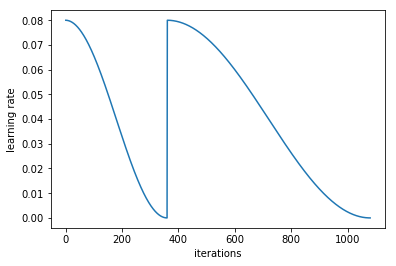

In [22]:
lr_cycle.plot_lr()

In [23]:
model.save('keras_resnet50.hdf5')

Make all layers trainable

In [24]:
for layer in model.layers: layer.trainable = True

In [25]:
callbacks = []
epochs = 7
lr_cycle = LR_Cycle(math.ceil(batches.samples/batch_size), cycle_len=1, cycle_mult=2, epochs=epochs)
callbacks.append(lr_cycle)

SGD2 is a modified version of Keras' SGD that accepts multiple learning rates for different parts of the model.  It accepts an early layer and then a later layer at which to start using the 2nd and 3rd learning rates

In [26]:
conv_layer = [layer for layer in model.layers if layer.name == 'res4a_branch2a'][0]
# fc_layer = [layer for layer in model.layers if layer.name == 'start_flat'][0] #use with finetune2
fc_layer = [layer for layer in model.layers if layer.name == 'fc1000'][0] #use with finetune1
sgd = SGD2(conv_layer, fc_layer, lr=[0.0001, .001, .01])
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [27]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), epochs=epochs, 
                        callbacks=callbacks, 
#                         validation_data=val_batches, 
#                         validation_steps=val_batches.samples
                       )

Epoch 1/7
360/360 [==============================] - 207s - loss: 0.0654 - acc: 0.9786   
Epoch 2/7
360/360 [==============================] - 205s - loss: 0.0656 - acc: 0.9786   
Epoch 3/7
360/360 [==============================] - 205s - loss: 0.0576 - acc: 0.9824   
Epoch 4/7
360/360 [==============================] - 205s - loss: 0.0586 - acc: 0.9823   
Epoch 5/7
360/360 [==============================] - 206s - loss: 0.0551 - acc: 0.9823   
Epoch 6/7
360/360 [==============================] - 205s - loss: 0.0511 - acc: 0.9846   
Epoch 7/7
360/360 [==============================] - 205s - loss: 0.0476 - acc: 0.9855   


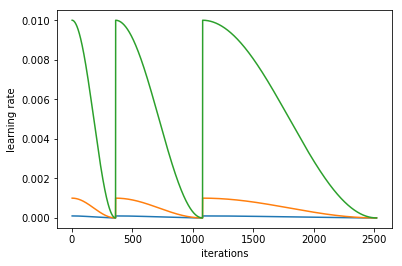

In [28]:
lr_cycle.plot_lr()

In [10]:
%%time
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

CPU times: user 1min 21s, sys: 3.39 s, total: 1min 25s
Wall time: 1min 39s


[0.050210296184948794, 0.98196930946291561]

In [31]:
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#note have to recompile in order to save. save function doesn't like multiple lr's :(
model.save('keras_resnet50_2.hdf5')

In [6]:
model = keras.models.load_model('keras_resnet50_2.hdf5')